# STATIONARITY AND  DIFFERENCING

# Stationarity
Time series data is said to be <em>stationary</em> if it does <em>not</em> exhibit trends or seasonality. That is, the mean, variance and covariance should be the same for any segment of the series, and are not functions of time.<br>
The file <tt>samples.csv</tt> contains made-up datasets that illustrate stationary and non-stationary data.

<div class="alert alert-info"><h3>For Further Reading:</h3>
<strong>
<a href='https://otexts.com/fpp2/stationarity.html'>Forecasting: Principles and Practice</a></strong>&nbsp;&nbsp;<font color=black>Stationarity and differencing</font></div>

In [1]:
import numpy as np
import pandas as pd

In [2]:
df= pd.read_csv('samples.csv',index_col=0,parse_dates=True)

In [3]:
df.head()

,a,b,c,d
1950-01-01,36,27,0,67
1950-02-01,58,22,3,31
1950-03-01,61,17,5,67
1950-04-01,37,15,8,47
1950-05-01,66,13,8,62


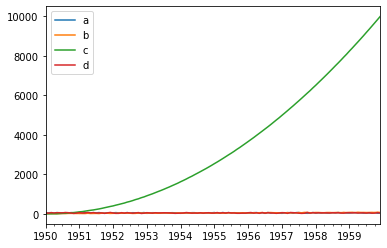

In [4]:
df.plot()

# Stationary Data

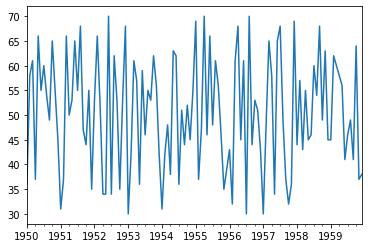

In [5]:
df['a'].plot()

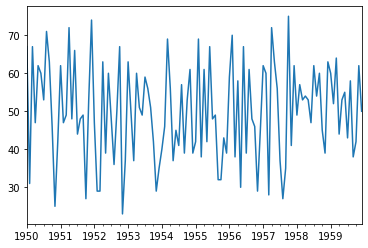

In [6]:
df['d'].plot()

# Non Stationary data

## Shows some kind of trend/ sesonality

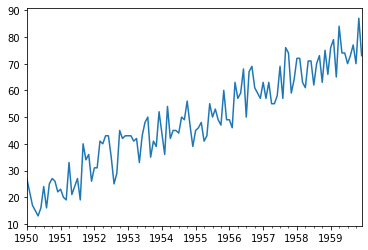

In [7]:
df['b'].plot()

# Differencing
## First Order Differencing
Non-stationary data can be made to look stationary through <em>differencing</em>. A simple method called <em>first order differencing</em> calculates the difference between consecutive observations.

&nbsp;&nbsp;&nbsp;&nbsp;$y^{\prime}_t = y_t - y_{t-1}$

In this way a linear trend is transformed into a horizontal set of values.


In [8]:
from statsmodels.tsa.statespace.tools import diff

In [10]:
df['b']

1950-01-01    27
1950-02-01    22
1950-03-01    17
1950-04-01    15
1950-05-01    13
              ..
1959-08-01    73
1959-09-01    77
1959-10-01    70
1959-11-01    87
1959-12-01    73
Name: b, Length: 120, dtype: int64

In [11]:
df['b'] - df['b'].shift(1)

1950-01-01     NaN
1950-02-01    -5.0
1950-03-01    -5.0
1950-04-01    -2.0
1950-05-01    -2.0
              ... 
1959-08-01     3.0
1959-09-01     4.0
1959-10-01    -7.0
1959-11-01    17.0
1959-12-01   -14.0
Name: b, Length: 120, dtype: float64

### Forecasting on first order differenced data
When forecasting with first order differences, the predicted values have to be added back in to the original values in order to obtain an appropriate forecast.

Let's say that the next five forecasted values after applying some model to <tt>df['d1b']</tt> are <tt>[7,-2,5,-1,12]</tt>. We need to perform an <em>inverse transformation</em> to obtain values in the scale of the original time series.

## Calling the differencing model from statsmodel

from statsmodels.tsa.statespace.tools import diff

In [12]:
diff(df['b'],k_diff=1)

1950-02-01    -5.0
1950-03-01    -5.0
1950-04-01    -2.0
1950-05-01    -2.0
1950-06-01     3.0
              ... 
1959-08-01     3.0
1959-09-01     4.0
1959-10-01    -7.0
1959-11-01    17.0
1959-12-01   -14.0
Name: b, Length: 119, dtype: float64

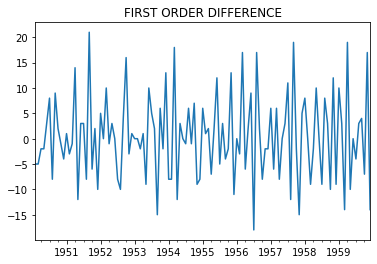

In [15]:
diff(df['b'],k_diff=1).plot(title="FIRST ORDER DIFFERENCE").autoscale(axis='x',tight=True);

In [16]:
# For our example we need to build a forecast series from scratch
# First determine the most recent date in the training set, to know where the forecast set should start
df[['b']].tail(3)

,b
1959-10-01,70
1959-11-01,87
1959-12-01,73


In [17]:
# Next set a DateTime index for the forecast set that extends 5 periods into the future
idx = pd.date_range('1960-01-01', periods=5, freq='MS')
z = pd.DataFrame([7,-2,5,-1,12],index=idx,columns=['Fcast'])
z

,Fcast
1960-01-01,7
1960-02-01,-2
1960-03-01,5
1960-04-01,-1
1960-05-01,12


The idea behind an inverse transformation is to start with the most recent value from the training set, and to add a cumulative sum of Fcast values to build the new forecast set. For this we'll use the pandas <tt>.cumsum()</tt> function which does the reverse of <tt>.diff()</tt>

In [19]:
z['forecast']=df['b'].iloc[-1] + z['Fcast'].cumsum()
z

,Fcast,forecast
1960-01-01,7,80
1960-02-01,-2,78
1960-03-01,5,83
1960-04-01,-1,82
1960-05-01,12,94


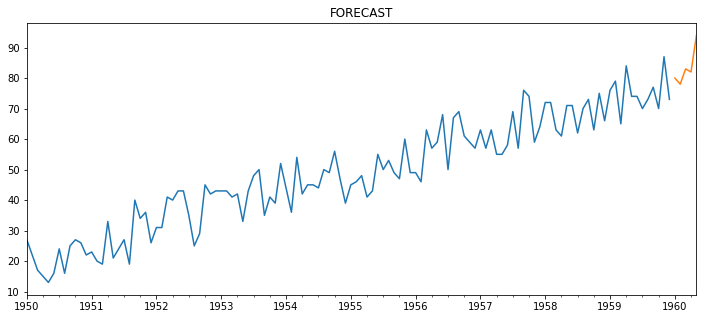

In [20]:
df['b'].plot(figsize=(12,5), title="FORECAST").autoscale(axis='x',tight=True)

z['forecast'].plot();

## Second order differencing
Sometimes the first difference is not enough to attain stationarity, particularly if the trend is not linear. We can difference the already differenced values again to obtain a second order set of values.

&nbsp;&nbsp;&nbsp;&nbsp;$\begin{split}y_{t}^{\prime\prime} &= y_{t}^{\prime} - y_{t-1}^{\prime} \\
&= (y_t - y_{t-1}) - (y_{t-1} - y_{t-2}) \\
&= y_t - 2y_{t-1} + y_{t-2}\end{split}$

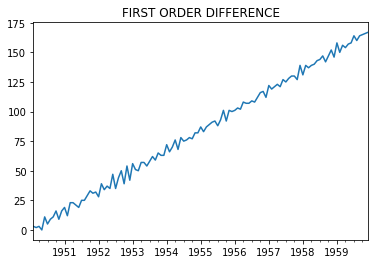

In [21]:
# First we'll look at the first order difference of dataset "c"
df['d1c'] = df['c'].diff()

df['d1c'].plot(title="FIRST ORDER DIFFERENCE").autoscale(axis='x',tight=True);

<strong>Now let's apply a second order difference to dataset "c".

In [22]:
# We can do this from the original time series in one step
df['d2c'] = df['c'].diff().diff()

df[['c','d1c','d2c']].head()

,c,d1c,d2c
1950-01-01,0,NaN,NaN
1950-02-01,3,3.0,NaN
1950-03-01,5,2.0,-1.0
1950-04-01,8,3.0,1.0
1950-05-01,8,0.0,-3.0


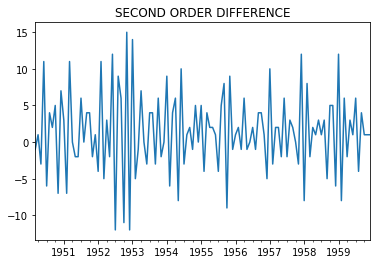

In [23]:
df['d2c'].plot(title="SECOND ORDER DIFFERENCE").autoscale(axis='x',tight=True);

### Forecasting on second order differenced data
As before, the prediction values have to be added back in to obtain an appropriate forecast.

To invert the second order transformation and obtain forecasted values for $\hat y_t$ we have to solve the second order equation for $y_t$:

&nbsp;&nbsp;&nbsp;&nbsp;$\begin{split}y_{t}^{\prime\prime} &= y_t - 2y_{t-1} + y_{t-2} \\
y_t &= y_{t}^{\prime\prime} + 2y_{t-1} - y_{t-2}\end{split}$

Let's say that the next five forecasted values after applying some model to <tt>df['d2c']</tt> are <tt>[7,-2,5,-1,12]</tt>.

In [24]:
# For our example we need to build a forecast series from scratch
idx = pd.date_range('1960-01-01', periods=5, freq='MS')
z = pd.DataFrame([7,-2,5,-1,12],index=idx,columns=['Fcast'])
z

,Fcast
1960-01-01,7
1960-02-01,-2
1960-03-01,5
1960-04-01,-1
1960-05-01,12


<strong>One way to invert a 2nd order transformation is to follow the formula above:

In [26]:
forecast = []

# Capture the two most recent values from the training set
v2,v1 = df['c'].iloc[-2:]

# Apply the formula
for i in z['Fcast']:
    newval = i + 2*v1 - v2
    forecast.append(newval)
    v2,v1 = v1,newval

z['forecast']=forecast
z

,Fcast,forecast
1960-01-01,7,10174
1960-02-01,-2,10346
1960-03-01,5,10523
1960-04-01,-1,10699
1960-05-01,12,10887


<strong>Another, perhaps more straightforward method is to create a first difference set from the second, then build the forecast set from the first difference. We'll again use the pandas <tt>.cumsum()</tt> function which does the reverse of <tt>.diff()</tt>

In [27]:
# Add the most recent first difference from the training set to the Fcast cumulative sum
z['firstdiff'] = (df['c'].iloc[-1]-df['c'].iloc[-2]) + z['Fcast'].cumsum()

# Now build the forecast values from the first difference set
z['forecast'] = df['c'].iloc[-1] + z['firstdiff'].cumsum()

z[['Fcast','firstdiff','forecast']]

,Fcast,firstdiff,forecast
1960-01-01,7,174,10174
1960-02-01,-2,172,10346
1960-03-01,5,177,10523
1960-04-01,-1,176,10699
1960-05-01,12,188,10887


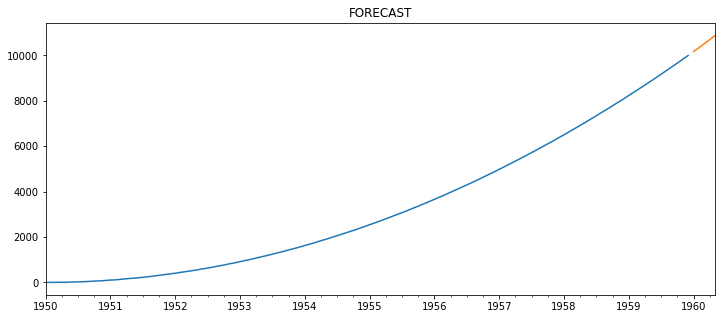

In [28]:
df['c'].plot(figsize=(12,5), title="FORECAST").autoscale(axis='x',tight=True)

z['forecast'].plot();

## Lagging
Also known as "backshifting", lagging notation reflects the value of $y$ at a prior point in time. This is a useful technique for performing <em>regressions</em> as we'll see in upcoming sections.

\begin{split}L{y_t} = y_{t-1} & \text{      one lag shifts the data back one period}\\
L^{2}{y_t} = y_{t-2} & \text{      two lags shift the data back two periods} \end{split}
<br><br>
<table>
<tr><td>$y_t$</td><td>6</td><td>8</td><td>3</td><td>4</td><td>9</td><td>2</td><td>5</td></tr>
<tr><td>$y_{t-1}$</td><td>8</td><td>3</td><td>4</td><td>9</td><td>2</td><td>5</td></tr>
<tr><td>$y_{t-2}$</td><td>3</td><td>4</td><td>9</td><td>2</td><td>5</td></tr>
</table>
